<a id="table-of-contents"></a>
# 📖 Time Series

- [🧱 Data Setup](#data-setup)
  - [📌 Simulate a univariate time series](#simulate-a-univariate-time-series)
  - [📈 Visualize the time series](#visualize-the-time-series)
  - [🧮 Create train/test split](#create-train-test-split)
  - [🌊 Optional: Add second seasonality/trend](#optional-add-second-seasonalitytrend)
- [📊 Exploratory Analysis](#exploratory-analysis)
  - [📉 Stationarity checks](#stationarity-checks)
  - [📐 Seasonality & trend decomposition](#seasonality--trend-decomposition)
  - [📏 Autocorrelation & partial autocorrelation](#autocorrelation--partial-autocorrelation)
- [🧪 Forecasting Baselines](#forecasting-baselines)
  - [📉 Naive Forecast](#naive-forecast)
  - [📊 Moving Average](#moving-average)
  - [📈 Simple Exponential Smoothing](#simple-exponential-smoothing)
  - [📋 Baseline Evaluation](#baseline-evaluation)
- [⚙️ ARIMA Family](#arima-family)
  - [🧩 AR, MA, ARMA](#ar-ma-arma)
  - [🛠️ ARIMA](#arima)
  - [🔁 SARIMA](#sarima)
  - [🔍 Residual diagnostics](#residual-diagnostics)
  - [📋 ARIMA Evaluation](#arima-evaluation)
- [🌊 State Space Models](#state-space-models)
  - [🧠 Intro to Kalman Filters](#intro-to-kalman-filters)
  - [📦 Statsmodels or Prophet](#statsmodels-or-prophet)
  - [📋 State Space Forecast Evaluation](#state-space-forecast-evaluation)
- [🧠 ML/Hybrid Approaches (Optional)](#mlhybrid-approaches-optional)
  - [🧮 Feature engineering](#feature-engineering)
  - [⚡ XGBoost or LightGBM](#xgboost-or-lightgbm)
  - [📋 ML Model Evaluation](#ml-model-evaluation)
- [🧮 Evaluation Summary](#evaluation-summary)
  - [📊 Metric comparison table](#metric-comparison-table)
  - [📈 Actual vs predicted plots](#actual-vs-predicted-plots)
- [📦 Deployment Considerations](#deployment-considerations)
  - [🧾 What to save](#what-to-save)
  - [🔄 Re-forecasting workflows](#re-forecasting-workflows)
- [🔚 Closing Notes](#closing-notes)
  - [🧠 Strengths/limits recap](#strengthslimits-recap)
  - [🚀 Next steps](#next-steps)

___


<a id="data-setup"></a>
# 🧱 Data Setup


<a id="simulate-a-univariate-time-series"></a>
#### 📌 Simulate a univariate time series


In [4]:
import numpy as np
import pandas as pd

# Set random seed for reproducibility
np.random.seed(42)

# Simulate time series components
n_periods = 200
trend = np.linspace(0, 10, n_periods)
seasonality = 5 * np.sin(2 * np.pi * np.arange(n_periods) / 12)
noise = np.random.normal(0, 1, n_periods)

# Final series
y = trend + seasonality + noise
dates = pd.date_range(start="2020-01-01", periods=n_periods, freq="M")
ts = pd.DataFrame({"date": dates, "value": y})

ts.head()


,date,value
0,2020-01-31,0.496714
1,2020-02-29,2.411987
2,2020-03-31,5.078318
3,2020-04-30,6.673784
4,2020-05-31,4.296979


<a id="visualize-the-time-series"></a>
#### 📈 Visualize the time series


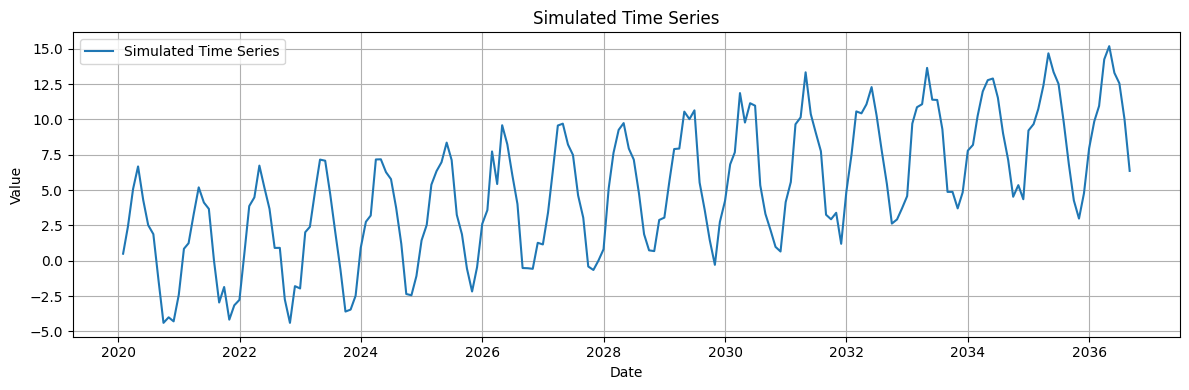

In [5]:
# 📈 Visualize the time series

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.plot(ts["date"], ts["value"], label="Simulated Time Series")
plt.title("Simulated Time Series")
plt.xlabel("Date")
plt.ylabel("Value")
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()


<a id="create-train-test-split"></a>
#### 🧮 Create train/test split


<details>
<summary><strong>📖 Click to Expand</strong></summary>

##### 🧮 Why It's Different
In time series, you can’t randomly split rows into train/test like traditional ML. Why?

- Time flows **sequentially**, so past should predict future.
- Shuffling would **leak future info into past** — a cardinal sin in forecasting.

##### ⚠️ Common Time Series Splits
- Use **chronological cutoff**, e.g., first 80% as train, last 20% as test.
- Use a **rolling forecast origin** if you want multiple test windows.
- For production-style setups, use a **fixed origin test set** and predict forward.

</details>


In [7]:
train_ratio = 0.8
cutoff = int(len(ts) * train_ratio)

train = ts.iloc[:cutoff].copy()
test = ts.iloc[cutoff:].copy()

print(f"Train range: {train['date'].min().date()} to {train['date'].max().date()}")
print(f"Test range:  {test['date'].min().date()} to {test['date'].max().date()}")

print(f"Train shape: {train.shape}")
print(f"Test shape: {test.shape}")


Train range: 2020-01-31 to 2033-04-30
Test range:  2033-05-31 to 2036-08-31
Train shape: (160, 2)
Test shape: (40, 2)


<a id="optional-add-second-seasonalitytrend"></a>
#### 🌊 Optional: Add second seasonality/trend


[Back to the top](#table-of-contents)
___


<a id="exploratory-analysis"></a>
# 📊 Exploratory Analysis


<a id="stationarity-checks"></a>
#### 📉 Stationarity checks


<details>
<summary><strong>📖 Click to Expand</strong></summary>

##### 🧪 What Does "Stationary" Mean?

Most forecasting models assume that the **statistical properties of a time series stay the same over time** — specifically:
- The **mean** doesn't change (no trend),
- The **variance** stays constant (no wild swings), and
- The relationships with its **own past values** remain stable.

This is called **stationarity**.

Why does it matter?
- Stationary series are **predictable**.
- Non-stationary data needs to be **transformed** (differenced, detrended, etc.) before modeling.

We’ll use:
- **Rolling mean / std** to visually check for stability
- **ADF test** (Augmented Dickey-Fuller) to statistically test for stationarity

</details>


In [11]:
# 📉 Stationarity checks

from statsmodels.tsa.stattools import adfuller
import plotly.graph_objects as go

# Rolling statistics
ts["rolling_mean"] = ts["value"].rolling(window=12).mean()
ts["rolling_std"] = ts["value"].rolling(window=12).std()

fig = go.Figure()
fig.add_trace(go.Scatter(x=ts["date"], y=ts["value"], mode="lines", name="Original"))
fig.add_trace(go.Scatter(x=ts["date"], y=ts["rolling_mean"], mode="lines", name="Rolling Mean (12)"))
fig.add_trace(go.Scatter(x=ts["date"], y=ts["rolling_std"], mode="lines", name="Rolling Std (12)"))

fig.update_layout(
    title="Rolling Mean & Standard Deviation",
    xaxis_title="Date",
    yaxis_title="Value",
    showlegend=True,
    template="plotly_white"
)
fig.show()

# ADF Test
adf_result = adfuller(ts["value"])
print(f"ADF Statistic: {adf_result[0]:.4f}")
print(f"p-value: {adf_result[1]:.4f}")
for key, value in adf_result[4].items():
    print(f"Critical Value ({key}): {value:.4f}")


ADF Statistic: -0.1689
p-value: 0.9421
Critical Value (1%): -3.4658
Critical Value (5%): -2.8771
Critical Value (10%): -2.5751


<a id="seasonality--trend-decomposition"></a>
#### 📐 Seasonality & trend decomposition


<details>
<summary><strong>📖 Click to Expand</strong></summary>

##### 📐 What Is Decomposition?

Decomposition splits a time series into:
- **Trend**: Long-term progression (upward or downward movement)
- **Seasonality**: Regular, repeating patterns (e.g., monthly cycles)
- **Residual**: The leftover noise after removing trend & seasonality

Why care?
- It **reveals structure** in your data.
- Helps you decide whether to model trend, seasonality, or both.

</details>


In [12]:
# 📐 Seasonality & trend decomposition

from statsmodels.tsa.seasonal import seasonal_decompose

# Perform additive decomposition (suitable when components are independent)
decomp = seasonal_decompose(ts["value"], model="additive", period=12)

# Plot using Plotly
import plotly.subplots as sp

fig = sp.make_subplots(rows=4, cols=1, shared_xaxes=True, subplot_titles=["Original", "Trend", "Seasonality", "Residual"])

fig.add_trace(go.Scatter(x=ts["date"], y=decomp.observed, name="Original"), row=1, col=1)
fig.add_trace(go.Scatter(x=ts["date"], y=decomp.trend, name="Trend"), row=2, col=1)
fig.add_trace(go.Scatter(x=ts["date"], y=decomp.seasonal, name="Seasonality"), row=3, col=1)
fig.add_trace(go.Scatter(x=ts["date"], y=decomp.resid, name="Residual"), row=4, col=1)

fig.update_layout(
    height=800,
    title="Seasonal Decomposition (Additive)",
    showlegend=False,
    template="plotly_white"
)

fig.update_xaxes(title_text="Date", row=4, col=1)
fig.update_yaxes(title_text="Value", row=1, col=1)
fig.show()


<a id="autocorrelation--partial-autocorrelation"></a>
#### 📏 Autocorrelation & partial autocorrelation


<details>
<summary><strong>📖 Click to Expand</strong></summary>

##### 📏 Why These Plots?

- **ACF (Autocorrelation Function)** shows how a time series is **correlated with its past values** (lags).
- **PACF (Partial ACF)** isolates the **direct relationship** between the series and a specific lag.

Why use them?
- To **identify lag structures** in your data.
- To choose parameters for models like **ARIMA** (p, q):
  - ACF tailing off = use differencing
  - PACF cutting off at lag *k* = potential AR(k) model

</details>


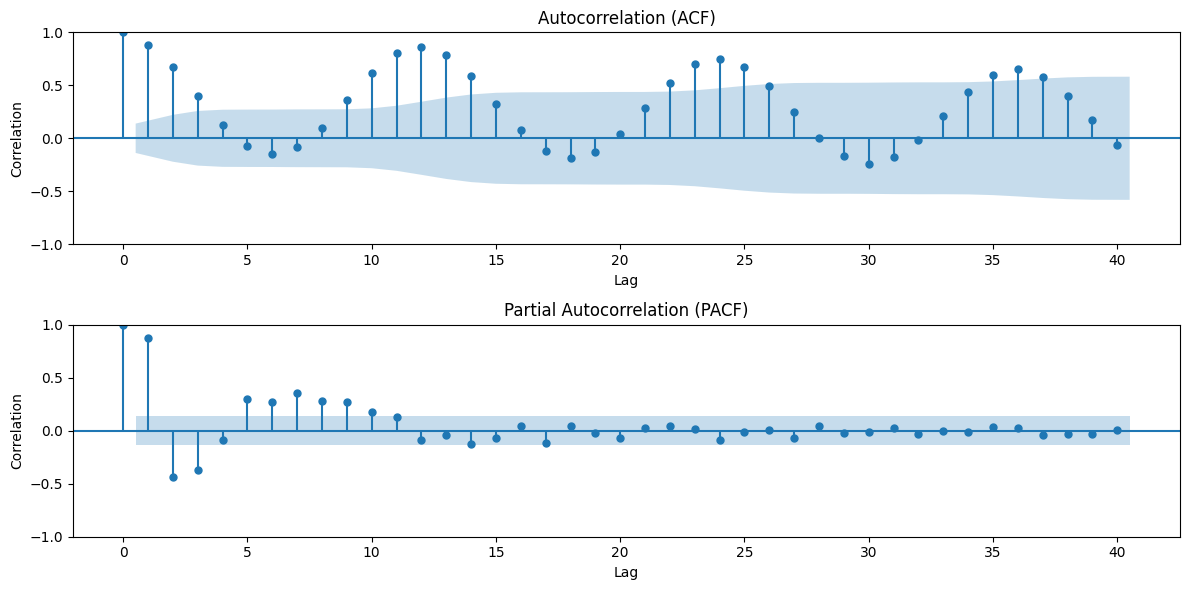

In [13]:
# 📏 Autocorrelation & partial autocorrelation

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(2, 1, figsize=(12, 6))

plot_acf(ts["value"], ax=ax[0], lags=40)
ax[0].set_title("Autocorrelation (ACF)")
ax[0].set_xlabel("Lag")
ax[0].set_ylabel("Correlation")
ax[0].grid(False)

plot_pacf(ts["value"], ax=ax[1], lags=40, method='ywm')
ax[1].set_title("Partial Autocorrelation (PACF)")
ax[1].set_xlabel("Lag")
ax[1].set_ylabel("Correlation")
ax[1].grid(False)

plt.tight_layout()
plt.show()


[Back to the top](#table-of-contents)
___


<a id="forecasting-baselines"></a>
# 🧪 Forecasting Baselines


<details>
<summary><strong>📖 Click to Expand</strong></summary>

##### 🧪 What Are Forecasting Baselines?

Before jumping into complex models like ARIMA or ML, it's smart to try **simple, interpretable methods**. They:
- Serve as **reference points** for evaluating more advanced models
- Are fast to run and surprisingly competitive for some time series

This section covers:
- Naive Forecast (last observed value)
- Moving Average
- Simple Exponential Smoothing (SES)
All are univariate and make **point forecasts only** (no uncertainty intervals yet).

</details>


<a id="naive-forecast"></a>
#### 📉 Naive Forecast


<details>
<summary><strong>📖 Click to Expand</strong></summary>

##### 📉 Naive Forecast

This is the **simplest possible model**:
- It assumes the **next value is equal to the last known value** from the training set.
- Great sanity check: if complex models can’t beat this, they’re overfitting.

</details>


In [ ]:
naive_forecast = test.copy()
naive_forecast["prediction"] = train["value"].iloc[-1]

import plotly.express as px

fig = px.line()
fig.add_scatter(x=train["date"], y=train["value"], name="Train")
fig.add_scatter(x=test["date"], y=test["value"], name="Actual")
fig.add_scatter(x=naive_forecast["date"], y=naive_forecast["prediction"], name="Naive Forecast")
fig.update_layout(
    title="Naive Forecast",
    xaxis_title="Date",
    yaxis_title="Value",
    template="plotly_white"
)
fig.show()


<a id="moving-average"></a>
#### 📊 Moving Average


<details>
<summary><strong>📖 Click to Expand</strong></summary>

##### 📊 Moving Average

Forecast is the **mean of the last N observations**.
- Smoother than naive forecast.
- Assumes short-term average is a good guess for next value.

Good when:
- There's **no strong trend or seasonality**.
- You want a simple but less noisy baseline.

</details>


In [ ]:
window = 12
moving_avg = test.copy()
moving_avg["prediction"] = train["value"].rolling(window).mean().iloc[-1]

fig = px.line()
fig.add_scatter(x=train["date"], y=train["value"], name="Train")
fig.add_scatter(x=test["date"], y=test["value"], name="Actual")
fig.add_scatter(x=moving_avg["date"], y=moving_avg["prediction"], name=f"Moving Average ({window})")
fig.update_layout(
    title="Moving Average Forecast",
    xaxis_title="Date",
    yaxis_title="Value",
    template="plotly_white"
)
fig.show()


<a id="simple-exponential-smoothing"></a>
#### 📈 Simple Exponential Smoothing


<details>
<summary><strong>📖 Click to Expand</strong></summary>

##### 📈 Simple Exponential Smoothing (SES)

Like moving average — but gives **more weight to recent observations**:
- Controlled by smoothing factor **alpha ∈ [0, 1]**
- Higher alpha = more recent points dominate

Ideal when:
- Data has **no clear trend or seasonality**
- You want more **reactive forecasts**

</details>


In [17]:
# 📈 Simple Exponential Smoothing

from statsmodels.tsa.holtwinters import SimpleExpSmoothing

model_ses = SimpleExpSmoothing(train["value"]).fit()
ses_forecast = test.copy()
ses_forecast["prediction"] = model_ses.forecast(len(test))

fig = px.line()
fig.add_scatter(x=train["date"], y=train["value"], name="Train")
fig.add_scatter(x=test["date"], y=test["value"], name="Actual")
fig.add_scatter(x=ses_forecast["date"], y=ses_forecast["prediction"], name="SES Forecast")
fig.update_layout(
    title="Simple Exponential Smoothing Forecast",
    xaxis_title="Date",
    yaxis_title="Value",
    template="plotly_white"
)
fig.show()


<a id="baseline-evaluation"></a>
#### 📋 Baseline Evaluation


<details>
<summary><strong>📖 Click to Expand</strong></summary>

##### 📋 Why Evaluate Even Simple Models?

Even "dumb" models like Naive Forecast can be **surprisingly hard to beat**.

Common error metrics:
- **MAE (Mean Absolute Error)**: Easy to interpret, robust to outliers
- **RMSE (Root Mean Square Error)**: Penalizes large errors more
- **MAPE (Mean Absolute Percentage Error)**: Good for scale-free comparison — but fails on 0s

A baseline that performs well sets the bar for any complex model.

</details>


In [23]:
# 📋 Baseline Evaluation

from sklearn.metrics import mean_absolute_error, mean_squared_error

def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

baseline_results = pd.DataFrame({
    "Model": ["Naive", "Moving Avg", "SES"],
    "MAE": [
        mean_absolute_error(test["value"], naive_forecast["prediction"]),
        mean_absolute_error(test["value"], moving_avg["prediction"]),
        mean_absolute_error(test["value"], ses_forecast["prediction"])
    ],
    "RMSE": [
        np.sqrt(mean_squared_error(test["value"], naive_forecast["prediction"])),
        np.sqrt(mean_squared_error(test["value"], moving_avg["prediction"])),
        np.sqrt(mean_squared_error(test["value"], ses_forecast["prediction"]))
    ],
    "MAPE (%)": [
        mape(test["value"], naive_forecast["prediction"]),
        mape(test["value"], moving_avg["prediction"]),
        mape(test["value"], ses_forecast["prediction"])
    ]
})

# Show table directly
print(baseline_results.round(3))

import plotly.express as px

# Melt to long format
melted = baseline_results.melt(id_vars="Model", var_name="Metric", value_name="Score")

fig = px.bar(melted, x="Model", y="Score", color="Metric", barmode="group",
             title="📊 Baseline Model Errors (Lower is Better)",
             text_auto=".2f")

fig.update_layout(template="plotly_white", yaxis_title="Error")
fig.show()



        Model    MAE   RMSE  MAPE (%)
0       Naive  4.610  5.613    79.707
1  Moving Avg  3.191  3.652    40.232
2         SES  4.610  5.613    79.707


[Back to the top](#table-of-contents)
___


<a id="arima-family"></a>
# ⚙️ ARIMA Family


<a id="ar-ma-arma"></a>
#### 🧩 AR, MA, ARMA


<a id="arima"></a>
#### 🛠️ ARIMA


<a id="sarima"></a>
#### 🔁 SARIMA


<a id="residual-diagnostics"></a>
#### 🔍 Residual diagnostics


<a id="arima-evaluation"></a>
#### 📋 ARIMA Evaluation


[Back to the top](#table-of-contents)
___


<a id="state-space-models"></a>
# 🌊 State Space Models


<a id="intro-to-kalman-filters"></a>
#### 🧠 Intro to Kalman Filters


<a id="statsmodels-or-prophet"></a>
#### 📦 Statsmodels or Prophet


<a id="state-space-forecast-evaluation"></a>
#### 📋 State Space Forecast Evaluation


[Back to the top](#table-of-contents)
___


<a id="mlhybrid-approaches-optional"></a>
# 🧠 ML/Hybrid Approaches (Optional)


<a id="feature-engineering"></a>
#### 🧮 Feature engineering


<a id="xgboost-or-lightgbm"></a>
#### ⚡ XGBoost or LightGBM


<a id="ml-model-evaluation"></a>
#### 📋 ML Model Evaluation


[Back to the top](#table-of-contents)
___


<a id="evaluation-summary"></a>
# 🧮 Evaluation Summary


<a id="metric-comparison-table"></a>
#### 📊 Metric comparison table


<a id="actual-vs-predicted-plots"></a>
#### 📈 Actual vs predicted plots


[Back to the top](#table-of-contents)
___


<a id="deployment-considerations"></a>
# 📦 Deployment Considerations


<a id="what-to-save"></a>
#### 🧾 What to save


<a id="re-forecasting-workflows"></a>
#### 🔄 Re-forecasting workflows


[Back to the top](#table-of-contents)
___


<a id="closing-notes"></a>
# 🔚 Closing Notes


<a id="strengthslimits-recap"></a>
#### 🧠 Strengths/limits recap


<a id="next-steps"></a>
#### 🚀 Next steps


[Back to the top](#table-of-contents)
___
